# Speed Comparisons between the Numpy an TF implementations of the DTCWT
Operations were performed on a system with a GTX 1080 GPU and Intel Xeon CPU E5-2660 CPU

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import datasets
import dtcwt
import dtcwt.tf
import tensorflow as tf
from tensorflow.python.client import timeline
from time import time
import numpy as np
import os
import py3nvml
plt.style.use('seaborn')
py3nvml.grab_gpus(1, gpu_fraction=0.95);

# Analysis of Small Images

## DTCWT on a single small image (64x64)

In [ ]:
# Create the input
h, w = 64, 64
in_ = np.random.randn(1,h,w)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
fwd = dtcwt.Transform2d()        # Numpy Transform
fwd_tf = dtcwt.tf.Transform2d()  # Tensorflow Transform

in_placeholder = tf.placeholder(tf.float32, [None, h, w])
out_tf = fwd_tf.forward_channels(in_placeholder, data_format='nhw', nlevels=nlevels)
out_fft = tf.fft2d(tf.cast(in_placeholder, tf.complex64))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Numpy Implementation

In [ ]:
small_np = %timeit -o for i in in_: fwd.forward(i, nlevels=nlevels)

6.57 ms ± 531 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### TF implementation

In [ ]:
small_tf = %timeit -o sess.run(out_tf.lowpass_op, {in_placeholder: in_})

1.76 ms ± 45.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### (Comparison) Using an FFT in Tensorflow
We can safely assume that something like the FFT is an optimized, fast operation to do. This is a good yardstick to gauge the overheads with working on a GPU

In [ ]:
%timeit sess.run(out_fft, {in_placeholder: in_})

12.4 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## DTCWT on a batch of small images (100x64x64)

In [ ]:
in_ = np.random.randn(100,h,w)

### Numpy Implementation

In [ ]:
small_np_batch = %timeit -o for i in in_: fwd.forward(i, nlevels=nlevels)

673 ms ± 46.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### TF implementation

In [ ]:
small_tf_batch = %timeit -o sess.run(out_tf.lowpass_op, {in_placeholder: in_})

2.53 ms ± 53.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### (Comparison) Using an FFT in Tensorflow

In [ ]:
%timeit sess.run(out_fft, {in_placeholder: in_})

13.5 ms ± 553 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Small Image Conclusion

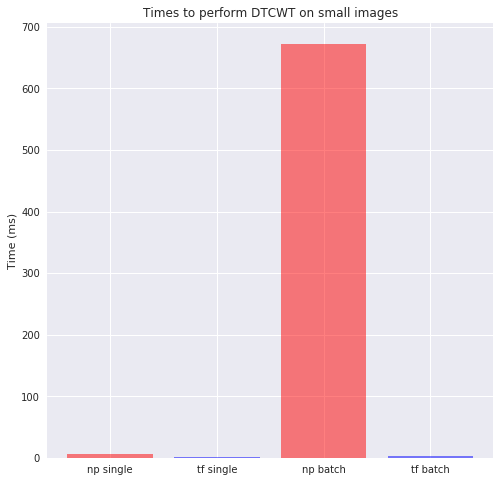

In [ ]:
objects = ('np single', 'tf single', 'np batch', 'tf batch')
y_pos = np.arange(len(objects))
performance = [small_np.average, small_tf.average, small_np_batch.average, small_tf_batch.average]
performance = [i*1000 for i in performance]
fig, ax = plt.subplots(1, figsize=(8,8))
ax.bar(y_pos, performance, align='center', alpha=0.5, color=['red', 'blue'])
plt.xticks(y_pos, objects)
plt.ylabel('Time (ms)')
plt.title('Times to perform DTCWT on small images')
plt.show()

# Analysis of Large Images

## DTCWT on a single large image (512x512)

In [ ]:
# Create the input
h, w = 512, 512
in_ = np.random.randn(1,h,w)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
fwd = dtcwt.Transform2d()        # Numpy Transform
fwd_tf = dtcwt.tf.Transform2d()  # Tensorflow Transform

in_placeholder = tf.placeholder(tf.float32, [None, h, w])
out_tf = fwd_tf.forward_channels(in_placeholder, data_format='nhw', nlevels=nlevels)
out_fft = tf.fft2d(tf.cast(in_placeholder, tf.complex64))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Numpy Implementation

In [ ]:
large_np = %timeit -o for i in in_: fwd.forward(i, nlevels=nlevels)

58.7 ms ± 366 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### TF implementation

In [ ]:
large_tf = %timeit -o sess.run(out_tf.lowpass_op, {in_placeholder: in_})

2.32 ms ± 52 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### (Comparison) Using an FFT in Tensorflow

In [ ]:
%timeit sess.run(out_fft, {in_placeholder: in_})

13.1 ms ± 505 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## DTCWT on a batch of large images (100x512x512)
Batches are something tensorflow naturally handles. This should widen the gap as we only have to copy data to the GPU once for multiple images

In [ ]:
in_ = np.random.randn(100,512,512)

### Numpy Implementation

In [ ]:
large_np_batch = %timeit -o for i in in_: fwd.forward(i, nlevels=nlevels).lowpass

5.77 s ± 144 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### TF implementation

In [ ]:
large_tf_batch = %timeit -o  sess.run(out_tf.lowpass_op, {in_placeholder: in_})

121 ms ± 6.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### (Comparison) Using an FFT in Tensorflow

In [ ]:
%timeit sess.run(out_fft, {in_placeholder: in_})

128 ms ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## DTCWT on a batch of large images with a convolution afterwards
This again should widen the gap, as having already calculated something on the GPU, we don't need to transfer the data there again

In [ ]:
h, w = 512, 512
in_ = np.random.randn(100, h, w)

### Numpy Implementation

In [ ]:
fwd = dtcwt.Transform2d()
tf.reset_default_graph()
sess = tf.Session()
highs = tf.placeholder(tf.float32, [None, h>>3, w>>3, 6])
weights = tf.get_variable('weights', shape=(5,5,6,64))
step = tf.nn.conv2d(highs, weights, strides=[1,1,1,1], padding='SAME')
sess.run(tf.global_variables_initializer())

In [ ]:
large_np_conv = %timeit -o sess.run(step, {highs: [abs(fwd.forward(i, nlevels=3).highpasses[2]) for i in in_]})

6.07 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### TF Implementation

In [ ]:
tf.reset_default_graph()
in_placeholder = tf.placeholder(tf.float32, [None, h, w])
fwd_tf = dtcwt.tf.Transform2d() 
out_tf = fwd_tf.forward_channels(in_placeholder, data_format='nhw', nlevels=3)
p = tf.abs(out_tf.highpasses_ops[2])
weights = tf.get_variable('weights', shape=(5,5,6,64))
out = tf.nn.conv2d(p, weights, strides=[1,1,1,1], padding='SAME')
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
large_tf_conv = %timeit -o sess.run(out, {in_placeholder: in_})

135 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Running DTCWT with TF backend on a CPU
Perhaps there is still a speed-up when using a CPU and tensorflow?

In [ ]:
# Create the input
h, w = 512, 512
in_ = np.random.randn(1,h,w)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
with tf.device("/cpu:0"):
    fwd_tf = dtcwt.tf.Transform2d()  # Tensorflow Transform
    in_placeholder = tf.placeholder(tf.float32, [None, h, w])
    out_tf = fwd_tf.forward_channels(in_placeholder, data_format='nhw', nlevels=nlevels)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
large_tf_cpu = %timeit -o  sess.run(out_tf.lowpass_op, {in_placeholder: in_})

14.4 ms ± 480 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
in_ = np.random.randn(100,h,w)
large_tf_batch_cpu = %timeit -o  sess.run(out_tf.lowpass_op, {in_placeholder: in_})

590 ms ± 7.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
tf.reset_default_graph()
with tf.device("/cpu:0"):
    in_placeholder = tf.placeholder(tf.float32, [None, h, w])
    fwd_tf = dtcwt.tf.Transform2d() 
    out_tf = fwd_tf.forward_channels(in_placeholder, data_format='nhw', nlevels=nlevels)
    p = tf.abs(out_tf.highpasses_ops[2])
    weights = tf.get_variable('weights', shape=(5,5,6,64))
    out = tf.nn.conv2d(p, weights, strides=[1,1,1,1], padding='SAME')
sess = tf.Session()
sess.run(tf.global_variables_initializer())
large_tf_conv_cpu = %timeit -o sess.run(out, {in_placeholder: in_})

681 ms ± 8.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Large Image Conclusion

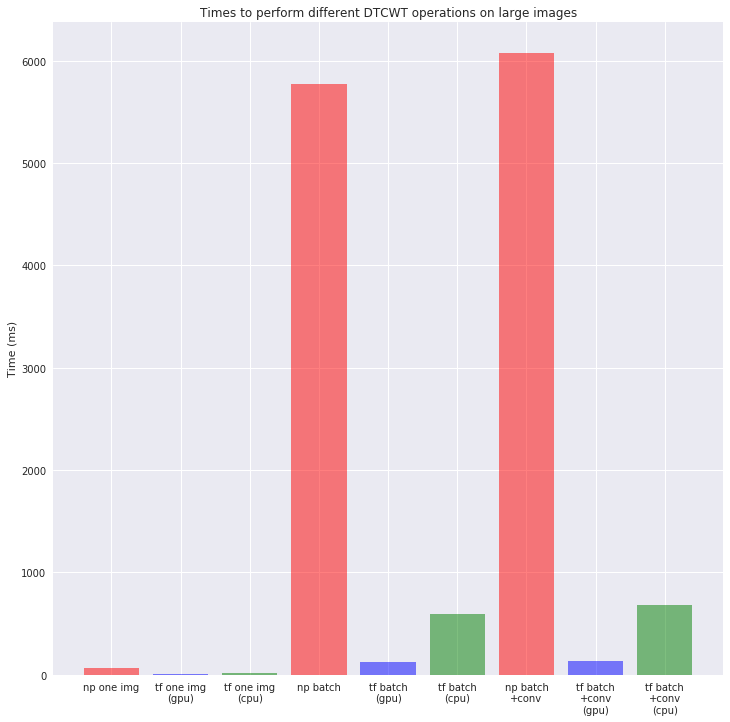

In [ ]:
objects = ('np one img', 'tf one img\n(gpu)', 'tf one img\n(cpu)', 'np batch', 'tf batch\n(gpu)', 
           'tf batch\n(cpu)', 'np batch\n+conv', 'tf batch\n+conv\n(gpu)', 'tf batch\n+conv\n(cpu)')
y_pos = np.arange(len(objects))
performance = [large_np.average, large_tf.average, large_tf_cpu.average, 
               large_np_batch.average, large_tf_batch.average, large_tf_batch_cpu.average,
               large_np_conv.average, large_tf_conv.average, large_tf_conv_cpu.average]
performance = [i*1000 for i in performance]
fig, ax = plt.subplots(1, figsize=(12,12))
ax.bar(y_pos, performance, align='center', alpha=0.5, color=['red', 'blue', 'green'])
plt.xticks(y_pos, objects)
plt.ylabel('Time (ms)')
plt.title('Times to perform different DTCWT operations on large images')
plt.show()

# Comparison to Convolutions
One important distinguising feature that would be nice would be to see a speed-up in using the dtcwt over using convolutions.

## First we can compare execution time on a CPU

In [ ]:
session_conf = tf.ConfigProto(
      intra_op_parallelism_threads=1,
      inter_op_parallelism_threads=1,
      device_count={'CPU': 1})

In [ ]:
# Create the input
h, w = 512, 512
in_ = np.random.randn(100,h,w,3)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
with tf.device("/cpu:0"):
    fwd_tf = dtcwt.tf.Transform2d()  # Tensorflow Transform
    in_placeholder = tf.placeholder(tf.float32, [None, h, w, 3])
    p = fwd_tf.forward_channels(in_placeholder, data_format='nhwc', nlevels=nlevels)
    Yl = p.lowpass_op

sess = tf.Session(config=session_conf)
sess.run(tf.global_variables_initializer())

start = time()
#dtcwt_cpu = %timeit -o  sess.run(Yl, {in_placeholder: in_})
sess.run(Yl, {in_placeholder: in_})
print(time()-start)

1.9493193626403809


In [ ]:
# Hard to say what an equivalent is? Let us compare to a single layer with 5x5x3x64
h, w = 512, 512
in_ = np.random.randn(100,h,w,3)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
with tf.device("/cpu:0"):
    in_placeholder = tf.placeholder(tf.float32, [None, h, w, 3])
    weights = tf.get_variable('weights', shape=(10,10,3,64))
    out = tf.nn.conv2d(in_placeholder, weights, strides=[1,1,1,1], padding='SAME')

sess = tf.Session(config=session_conf)
sess.run(tf.global_variables_initializer())
dtcwt_cpu = %timeit -o  sess.run(out, {in_placeholder: in_})

5.17 s ± 28.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Look at the Graph

In [ ]:
# Create the input
h, w = 512, 512
in_ = np.random.randn(1,h,w)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
fwd_tf = dtcwt.tf.Transform2d()  # Tensorflow Transform

in_placeholder = tf.placeholder(tf.float32, [None, h, w])
out_tf = fwd_tf.forward_channels(in_placeholder, data_format='nhw', nlevels=nlevels)
out_fft = tf.fft2d(tf.cast(in_placeholder, tf.complex64))
# A 3 layer DTCWT has approximately 70 multiply adds per pixel. Compare to a 7 by 10
# pure convolutional kernel. Then compare to a bigger one
out_simplec2d = tf.nn.conv2d(tf.expand_dims(in_placeholder, axis=-1),
                             tf.Variable(np.random.randn(10,7,1,1), dtype=tf.float32),
                             padding='SAME', strides=[1,1,1,1])
out_simplec2d_big = tf.nn.conv2d(tf.expand_dims(in_placeholder, axis=-1),
                             tf.Variable(np.random.randn(12,12,1,10), dtype=tf.float32),
                             padding='SAME', strides=[1,1,1,1])

options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped {} bytes>".format(size).encode('utf-8')
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [ ]:
show_graph(tf.get_default_graph().as_graph_def())

# Tensorflow Tracing
Let's have a look at the run times for these operations

In [ ]:
# Need to repeat it a few times as the first time is always much slower
for i in range(3):
    sess.run(out_tf.lowpass_op, {in_placeholder: np.random.randn(100,h,w)}, options=options, run_metadata=run_metadata)
    fetched_timeline = timeline.Timeline(run_metadata.step_stats)
    chrome_trace = fetched_timeline.generate_chrome_trace_format()
    with open('tf_profiling/timeline_dtcwt_%d.json' % i, 'w') as f:
        f.write(chrome_trace)

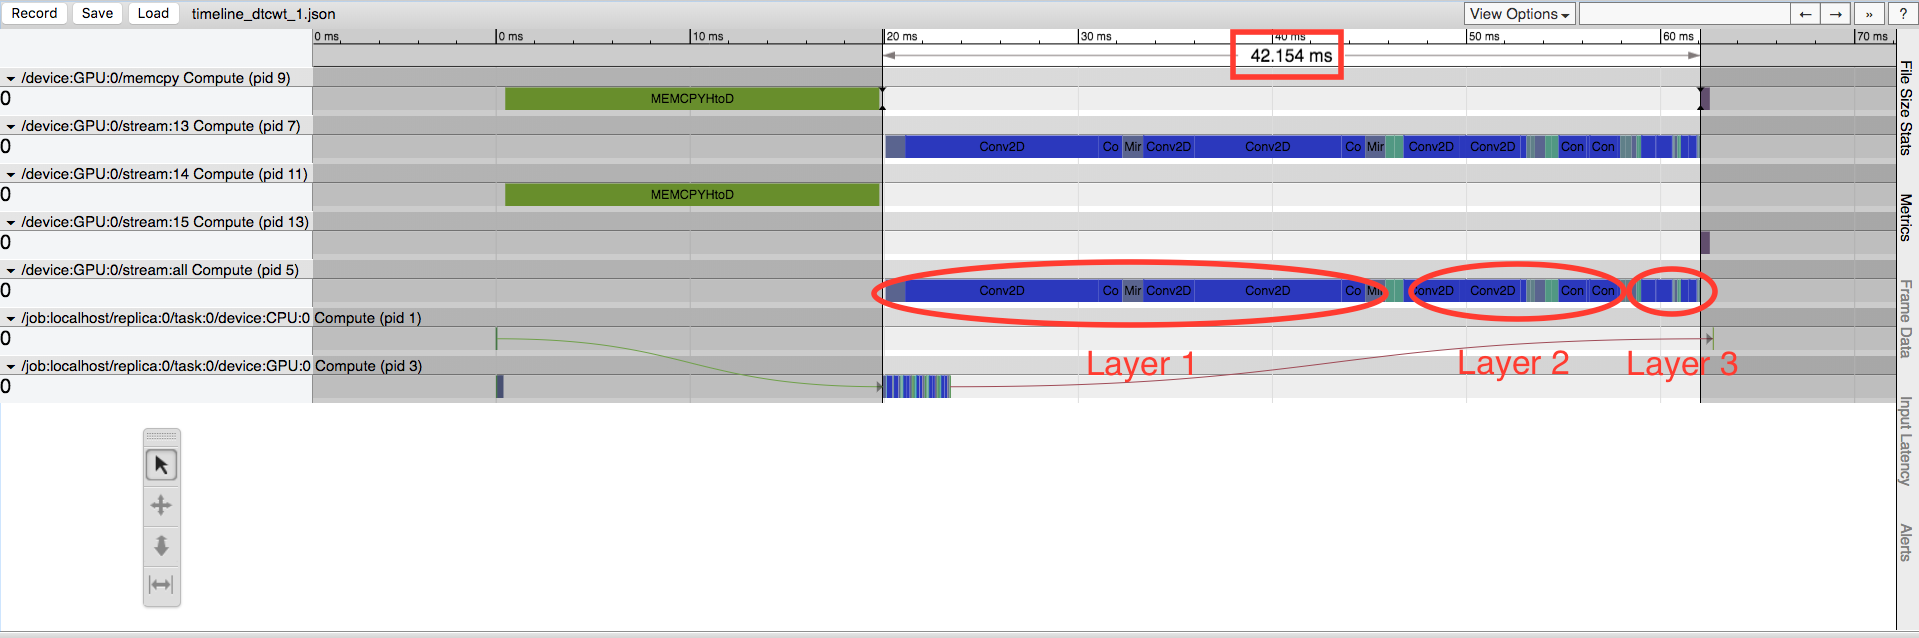

In [ ]:
for i in range(3):
    sess.run(out_simplec2d, {in_placeholder: np.random.randn(100,h,w)}, options=options, run_metadata=run_metadata)
    fetched_timeline = timeline.Timeline(run_metadata.step_stats)
    chrome_trace = fetched_timeline.generate_chrome_trace_format()
    with open('tf_profiling/timeline_conv_%d.json' % i, 'w') as f:
        f.write(chrome_trace)

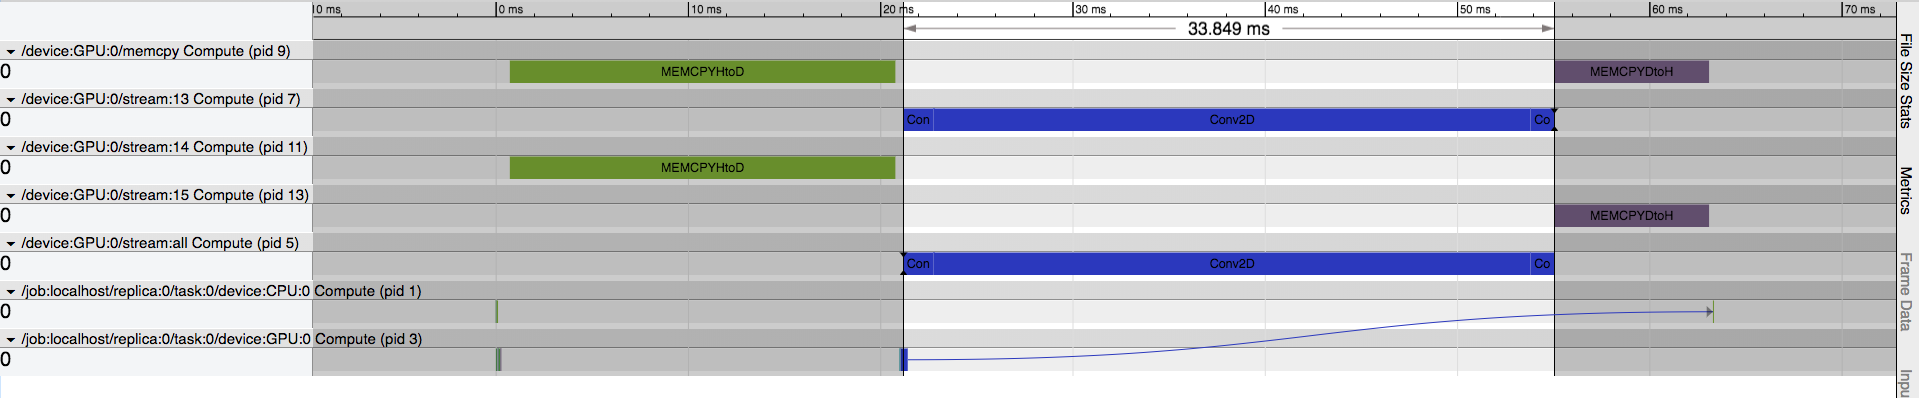

## What about a more complex operation? Say an input with channels too

In [ ]:
# Create the input
h, w = 512, 512

# Set up the transforms
nlevels = 3
c = 64
tf.reset_default_graph()
fwd_tf = dtcwt.tf.Transform2d()  # Tensorflow Transform

in_placeholder = tf.placeholder(tf.float32, [None, c, h, w])
out_tf = fwd_tf.forward_channels(in_placeholder, data_format='nchw', nlevels=nlevels)
y = fwd_tf.inverse_channels(out_tf, data_format='nchw')

# A 3 layer DTCWT has approximately 70 multiply adds per pixel. Compare to a 7 by 10
# pure convolutional kernel. 
out_simplec2d = tf.nn.conv2d(in_placeholder,
                             tf.Variable(np.random.randn(10,7,64,1), dtype=tf.float32),
                             padding='SAME', data_format='NCHW', strides=[1,1,1,1])

options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
# Need to repeat it a few times as the first time is always much slower
for i in range(3):
    sess.run(out_tf.lowpass_op, {in_placeholder: np.random.randn(20,c,h,w)}, options=options, run_metadata=run_metadata)
    fetched_timeline = timeline.Timeline(run_metadata.step_stats)
    chrome_trace = fetched_timeline.generate_chrome_trace_format()
    with open('tf_profiling/timeline2_dtcwt_ch_%d.json' % i, 'w') as f:
        f.write(chrome_trace)

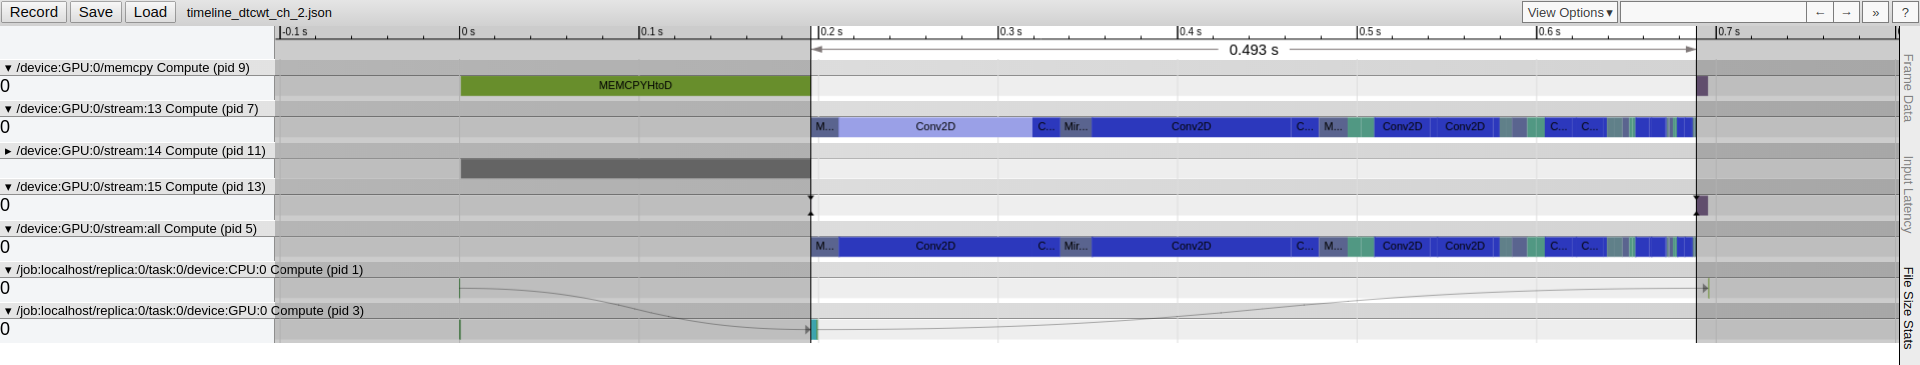

In [ ]:
# Also test the inverse transform
for i in range(3):
    sess.run(y, {in_placeholder: np.random.randn(10,c,h,w)}, options=options, run_metadata=run_metadata)
    fetched_timeline = timeline.Timeline(run_metadata.step_stats)
    chrome_trace = fetched_timeline.generate_chrome_trace_format()
    with open('tf_profiling/timeline2_dtcwt_inv_ch_%d.json' % i, 'w') as f:
        f.write(chrome_trace)

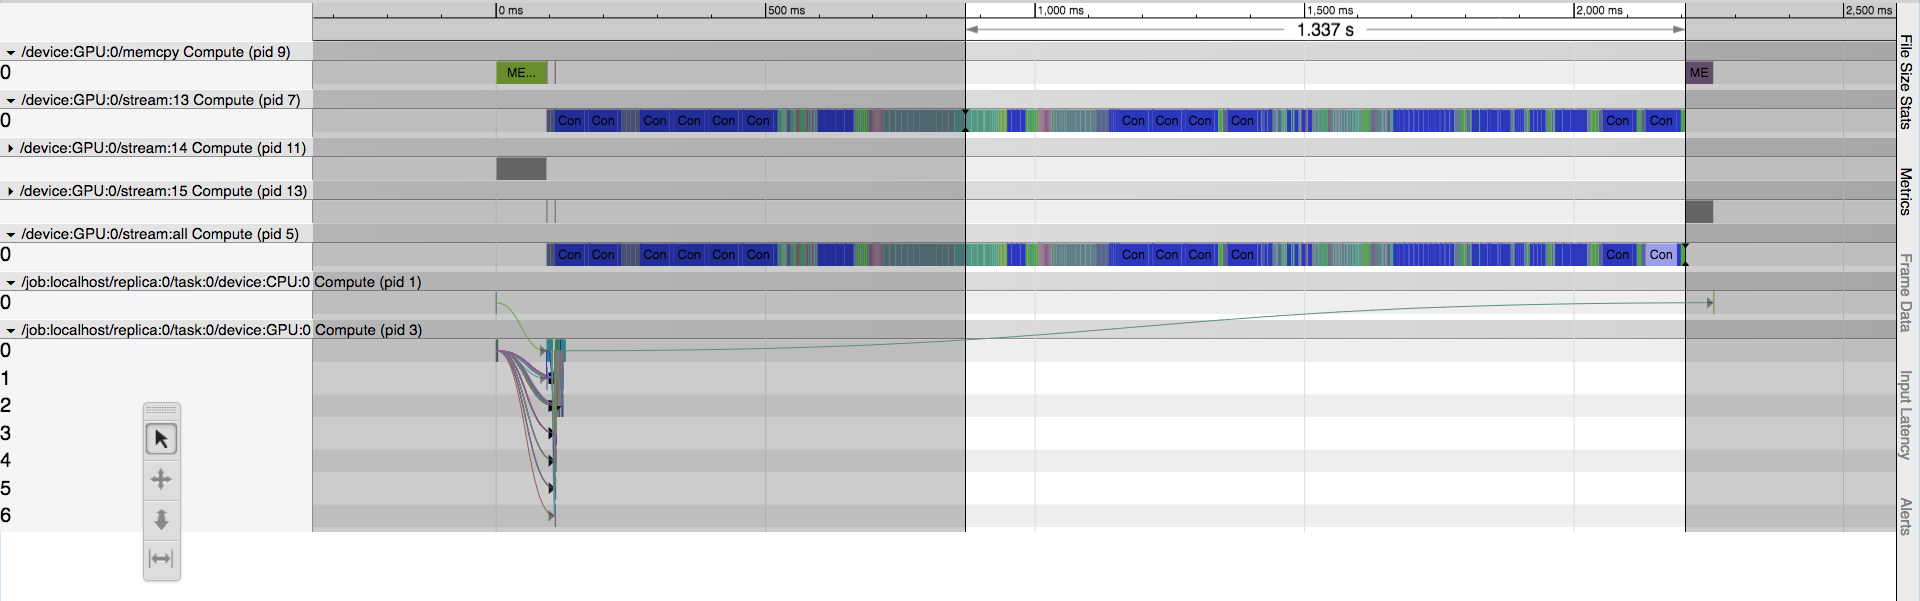

In [ ]:
for i in range(3):
    sess.run(out_simplec2d, {in_placeholder: np.random.randn(20,c,h,w)}, options=options, run_metadata=run_metadata)
    fetched_timeline = timeline.Timeline(run_metadata.step_stats)
    chrome_trace = fetched_timeline.generate_chrome_trace_format()
    with open('tf_profiling/timeline_conv_ch_%d.json' % i, 'w') as f:
        f.write(chrome_trace)

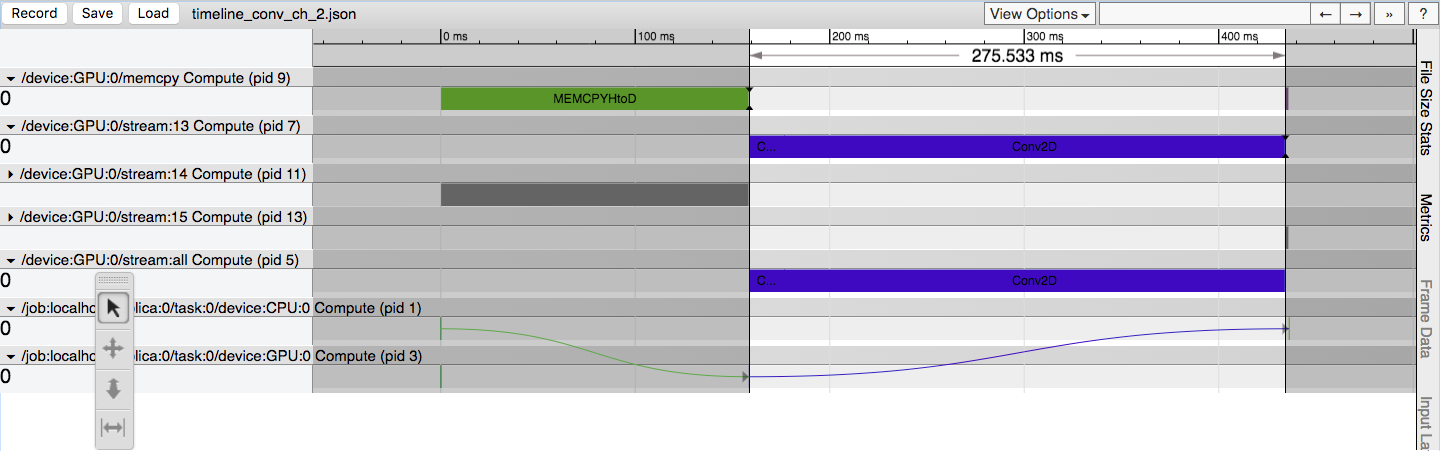

## Finally, try a forward DTCWT, some conv operations, and then an Inverse DTCWT

In [ ]:
_BIORT = 'near_sym_a'
_QSHIFT = 'qshift_a'
def dtcwt_gain_layer(inputs, filters, J, data_format):
    """ Performs DTCWT and then applies gain filters to create new activations
    in the wavelet space before taking inverse DTCWTs

    Inputs:
        inputs: tf.Tensor of size [batch, channels, H, W]
        filters: number of output channels
        J: number of layers to use in this decomposition
        data_format str: either "nchw" or "nhwc" indicating the shape of the
            activations.
    """
    xfm = dtcwt.tf.Transform2d(biort=_BIORT, qshift=_QSHIFT)
    s = inputs.get_shape().as_list()
    if data_format == 'channels_first':
        df = 'nchw'
        C = s[1]
    else:
        df = 'nhwc'
        C = s[-1]

    # Get the variables
    lp_initializer = tf.random_normal_initializer(mean=0, stddev=1/C)
    lp_reg = tf.contrib.layers.l2_regularizer(scale=0.001)
    lp_gains = tf.get_variable('lp_g', shape=(filters, C), dtype=tf.float32,
                               initializer=lp_initializer,
                               regularizer=lp_reg)

    phases = 2*np.pi*np.random.rand(filters, C, 6, J)
    bp_initializer_r = tf.constant_initializer(1/C * np.cos(phases))
    bp_initializer_i = tf.constant_initializer(1/C * np.sin(phases))
    bp_reg = tf.contrib.layers.l1_regularizer(scale=0.001)
    bp_gains_r = tf.get_variable('bp_g_r', shape=(filters, C, 6, J),
                                 dtype=tf.float32,
                                 initializer=bp_initializer_r,
                                 regularizer=bp_reg)
    bp_gains_i = tf.get_variable('bp_g_i', shape=(filters, C, 6, J),
                                 dtype=tf.float32,
                                 initializer=bp_initializer_i,
                                 regularizer=bp_reg)
    bp_gains = tf.complex(bp_gains_r, bp_gains_i)

    # Transform the input
    p = xfm.forward_channels(inputs, data_format=df, nlevels=J)
    c = xfm.inverse_channels(p, data_format=df, lp_gain=lp_gains,
                             gain_mask=bp_gains, sum_channels=True)

    return c

In [ ]:
h, w = 512, 512

# Set up the transforms
J = 3
tf.reset_default_graph()

in_placeholder = tf.placeholder(tf.float32, [None, h, w, 64])
y = dtcwt_gain_layer(in_placeholder, 64, J, data_format='channels_first')
# A 3 layer DTCWT has approximately 70 multiply adds per pixel. Compare to a 7 by 10
# pure convolutional kernel
out_simplec2d = tf.nn.conv2d(in_placeholder,
                             tf.Variable(np.random.randn(5,5,64,64), dtype=tf.float32),
                             padding='SAME', strides=[1,1,1,1], data_format='NHWC')

options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
for i in range(3):
    sess.run(y, {in_placeholder: np.random.randn(10,h,w,64)}, options=options, run_metadata=run_metadata)
    fetched_timeline = timeline.Timeline(run_metadata.step_stats)
    chrome_trace = fetched_timeline.generate_chrome_trace_format()
    with open('tf_profiling/timeline_dtcwt_layer_%d.json' % i, 'w') as f:
        f.write(chrome_trace)

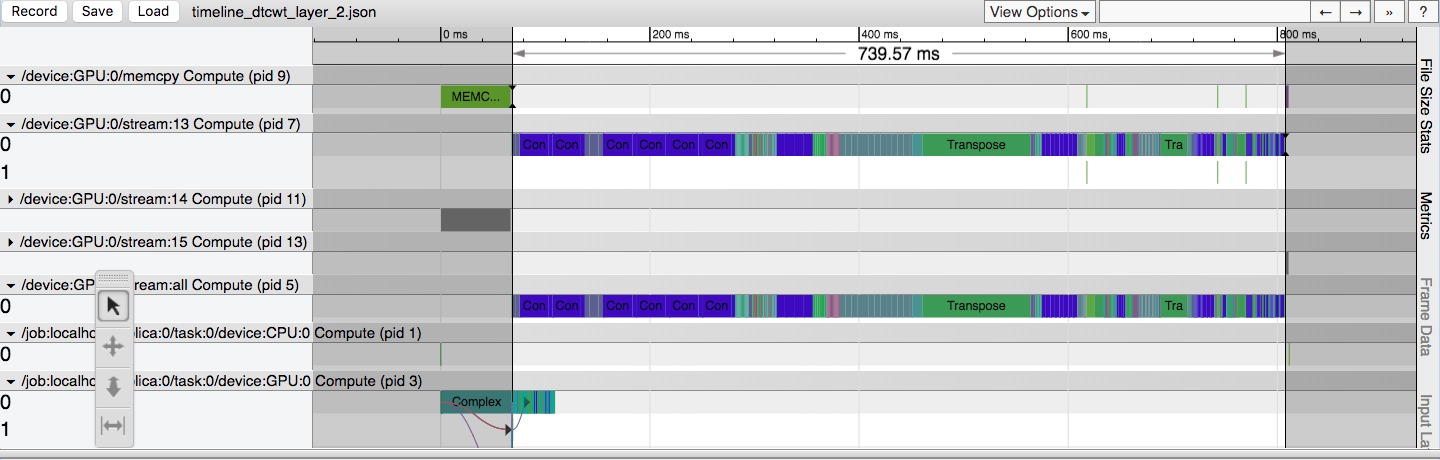

In [ ]:
for i in range(3):
    sess.run(out_simplec2d, {in_placeholder: np.random.randn(10,h,w, 64)}, options=options, run_metadata=run_metadata)
    fetched_timeline = timeline.Timeline(run_metadata.step_stats)
    chrome_trace = fetched_timeline.generate_chrome_trace_format()
    with open('tf_profiling/timeline_conv_layer_%d.json' % i, 'w') as f:
        f.write(chrome_trace)

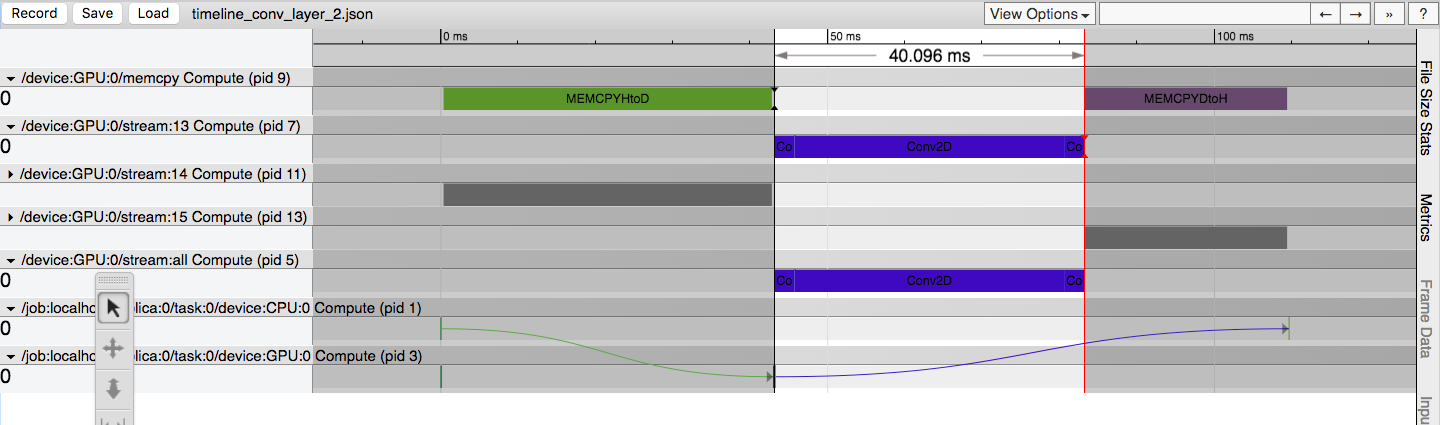